# Свёртка

In [1]:
class MyConv2d:
    def __init__(self, tensor, kernel, stride=(1,1)):
        self.tensor = tensor
        self.kernel = kernel
        self.stride = stride
        w = int((tensor.size()[1] - kernel.size()[1]) / stride[0] + 1)  # ширина выхода
        h = int((tensor.size()[2] - kernel.size()[2]) / stride[1] + 1)  # длина выхода
        self.output = torch.FloatTensor(w, h)

    def scalar_product(self):  # свертка с помощью скалярного произведения
        for i in range(self.output.size()[0]):
            for j in range(self.output.size()[1]):
                # скалярное произведение кубов размером axbxc {a,b,c - параметры кернела}
                self.output[i][j] = torch.sum(
                                    self.tensor[:, 
                                                i * self.stride[0]:i * self.stride[0] + self.kernel.size()[1], 
                                                j * self.stride[1]:j * self.stride[1] + self.kernel.size()[2]] 
                                  * self.kernel)

    def boost_bounds(self):  # бустинг границ
        self.output[self.output >= 0.5] = 1
        self.output[self.output < 0.5] = 0

    def average(self): # усреднение
        self.output /= 4
        
    def get_output(self, boost = False, average = False):  # расчет выхода
        self.scalar_product()
        if boost:
            self.boost_bounds()
        if average:
            self.average()

        return self.output

## Тестируем функцию свертки

### Загружаем картинку 

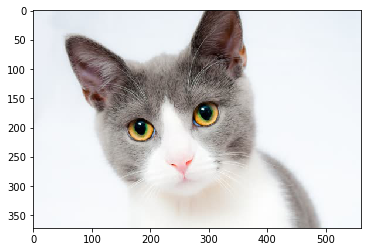

In [2]:
import torch
import torchvision as tv

# библиотека для отрисовки графиков, картинок .... 
import matplotlib.pyplot as plt
%matplotlib inline

# загрузка изображений
from PIL import Image
cat_convolve= Image.open('./imgs/cat_convolve.jpg')
plt.imshow(cat_convolve)

### Превращаем кота в тензор

In [3]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
print (cat_tensor.size())

torch.Size([3, 372, 560])


### Сворачиваем картинку ядром, детектор границ
$$
\begin{bmatrix}
    -1       & -1 & -1  \\
    -1       & 8 & -1 \\
    -1       & -1 & -1
\end{bmatrix}
$$

### Создаем фильтр ядра и заполняем его -1 & 8

In [4]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(-1)
filter_kernel[:,1,1] = 8
print(filter_kernel.size())

torch.Size([3, 3, 3])


### Делаем свертку картинки ядром

torch.Size([370, 558])


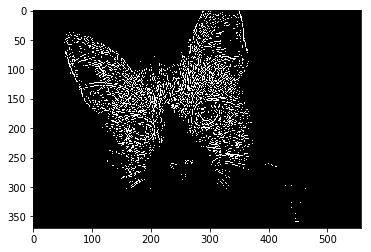

In [5]:
cat = MyConv2d(cat_tensor, filter_kernel).get_output(boost = True)
print(cat.size())
plt.imshow(cat.numpy(), cmap='gray')

### Горизонтальные границы
$$
\begin{bmatrix}
    1       & 1 & 1  \\
    0       & 0 & 0 \\
    -1       & -1 & -1
\end{bmatrix}
$$

In [6]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,1,:] = 0
filter_kernel[:,2,:] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


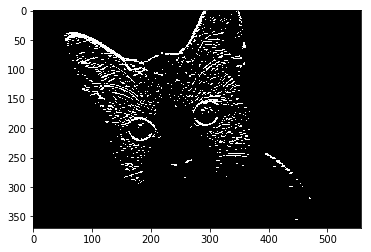

In [7]:
cat = MyConv2d(cat_tensor, filter_kernel).get_output(boost = True)
print(cat.size())
plt.imshow(cat.numpy(), cmap='gray')

### Вертикальные границы
$$
\begin{bmatrix}
    1       & 0 & -1  \\
    1       & 0 & -1 \\
    1       & 0 & -1
\end{bmatrix}
$$

In [8]:
filter_kernel = torch.FloatTensor(3,3,3).fill_(1)
filter_kernel[:,:,1] = 0
filter_kernel[:,:,2] = -1
print(filter_kernel.size())

torch.Size([3, 3, 3])


torch.Size([370, 558])


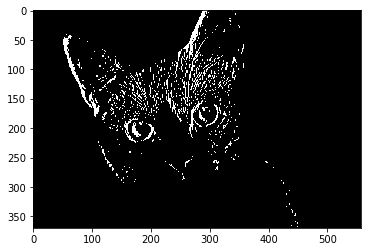

In [9]:
cat = MyConv2d(cat_tensor, filter_kernel).get_output(boost = True)
print(cat.size())
plt.imshow(cat.numpy(), cmap='gray')

### Используем ядро 

$$ \begin{bmatrix}
    1 & 1 \\
    1 & 1
\end{bmatrix}$$

### и stride 2

torch.Size([186, 280])


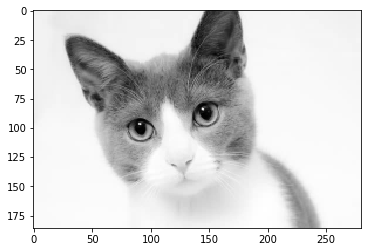

In [10]:
filter_kernelx2 = torch.FloatTensor(3,2,2).fill_(1)
o_image = MyConv2d(cat_tensor, filter_kernelx2, stride=(2,2)).get_output(average = True)
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

### Ядро свертки с гаусовым распределением

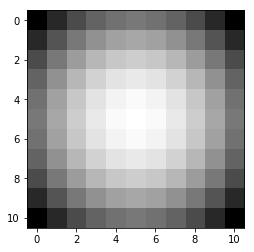

In [11]:
import scipy.ndimage as ndi
import numpy as np
sigma = 10    # параметр распределение
patern_size = 101 # максимальный размер ядра свертки
kernel_size = 10  # реальный размер свертки
x = np.zeros((patern_size, patern_size))
x [patern_size//2,patern_size//2]= 1

# делаем ядро с гаусовым распределением
gause_kernel = ndi.filters.gaussian_filter(x, sigma=sigma)
# вырезаем из центра наш кернел
gause_kernel = gause_kernel[(patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1, \
                (patern_size//2-(kernel_size//2)):(patern_size//2+(kernel_size//2))+1]
# вот он
plt.imshow(gause_kernel, interpolation='none', cmap=plt.get_cmap('gray'))

# Делаем свертку 

torch.Size([362, 550])


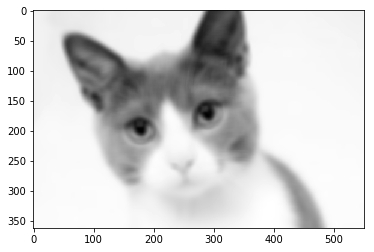

In [12]:
o_image = MyConv2d(cat_tensor, torch.from_numpy(gause_kernel).float().unsqueeze(0)).get_output()
print(o_image.size())
plt.imshow(o_image.numpy(), cmap='gray')

In [13]:
import torch.nn as nn
import math

class BatchNorm2d(nn.Module):
    
    def __init__(self, in_channels, afine=True, beta=0.9, epsilon=1e-8):
        super().__init__()
        
        self.in_channels = in_channels
        self.beta        = beta
        self.epsilon     = epsilon
        self.mean        = torch.zeros(in_channels) # среднее
        self.var         = torch.ones(in_channels) # дисперсия
        self.b           = torch.zeros(in_channels) 
        self.v           = torch.zeros(in_channels)
        self.s           = torch.ones(in_channels) 
        if afine: # с афинными преобразованиями       
            self.gamma = torch.empty(in_channels).uniform_()
        else: # без них
            self.gamma = torch.ones(in_channels)

    def forward(self, x):
        
        for i in range(self.in_channels):
            
            # обучаем параметры
            if self.training:
                self.mean[i] = torch.mean(x[:, i])
                self.var[i]  = torch.var(x[:, i])
                
                self.v[i] = self.beta * self.v[i] + (1 - self.beta) * self.mean[i]
                self.s[i] = self.beta * self.s[i] + (1 - self.beta) * self.var[i]
        
            # нормализуем в обоих случаях
            x[:,i] = (x[:,i] - self.v[i]) / math.sqrt(self.s[i] + self.epsilon) * self.gamma[i] + self.b[i]
            
        return x
                    


### Проверяем работу батч нормадлизации на котэ

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


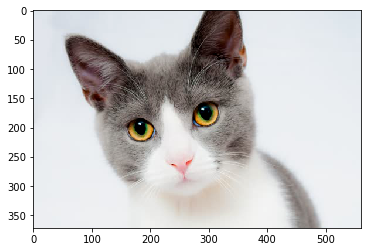

In [14]:
cat_tensor = tv.transforms.ToTensor()(cat_convolve)
# Без афинных преобразований, за один проход не должно быть значительных изменений, потому что начальные значеня среднего 0 
# и дисперсии 1 
bn = BatchNorm2d(3, afine=False)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 372, 560])


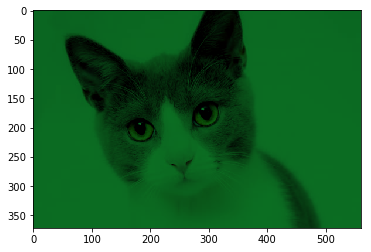

In [15]:
# C афинными преобразованиями, должен нагладыватья uniform_ шум при каждом новом запуске
bn = BatchNorm2d(3, afine=True)
# добавляем размерность батча
o_image = bn(cat_tensor.unsqueeze(0))
# убираем размерность батча
o_image = o_image.squeeze()
print (o_image.size())
# для вывода картинки транспонируем тензор и превращаем его в numpy
plt.imshow(o_image.transpose(0,2).transpose(0,1).numpy())

### Проверим как реализация работает на большом сете картинок

In [16]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [17]:
# Загружаем MNIST
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home='./')
X = mnist['data']
# переходим к формату тензоров pytorch
X = X.reshape((-1, 1, 28, 28))
X = X.astype('float')
print(X.shape)

(70000, 1, 28, 28)


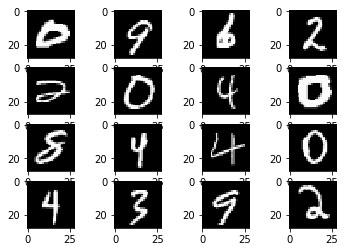

In [18]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    plt.imshow(I, cmap='gray')

### Тестируем модуль батч нормализации на мнисте
Прогоняем весь поток картинок (1 эпоха) с размером батча 32, и смотрим как расчитываются средние значения в процессе тренировки

In [19]:
# функция тестирования BN
def test_batch_norm(bn):
    bn.train(True)
    # количество эпох и размер батча
    c_epoch = 1
    batch_size = 32
    # данные для отчета
    mean_curve = []
    var_curve = []
    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            bn(x)
            mean_curve += [ float(bn.v) ] 
            var_curve +=  [ float(bn.s) ]
    return mean_curve, var_curve

In [20]:
# параметры beta = 0.9, 0.99, 0.5
bn_09 = BatchNorm2d(1, beta=0.9)
bn_099 = BatchNorm2d(1, beta=0.99)
bn_05 = BatchNorm2d(1, beta=0.5)
# ставим обучение в True
bn.train(True)
# количество эпох и размер батча
c_epoch = 1
batch_size = 32
# данные для отчета
mean_curve_09, var_curve_09 = test_batch_norm(bn_09)
mean_curve_099, var_curve_099 = test_batch_norm(bn_099)
mean_curve_05, var_curve_05 = test_batch_norm(bn_05)

Смотрим какие значения средних и дисперсий у нас получились

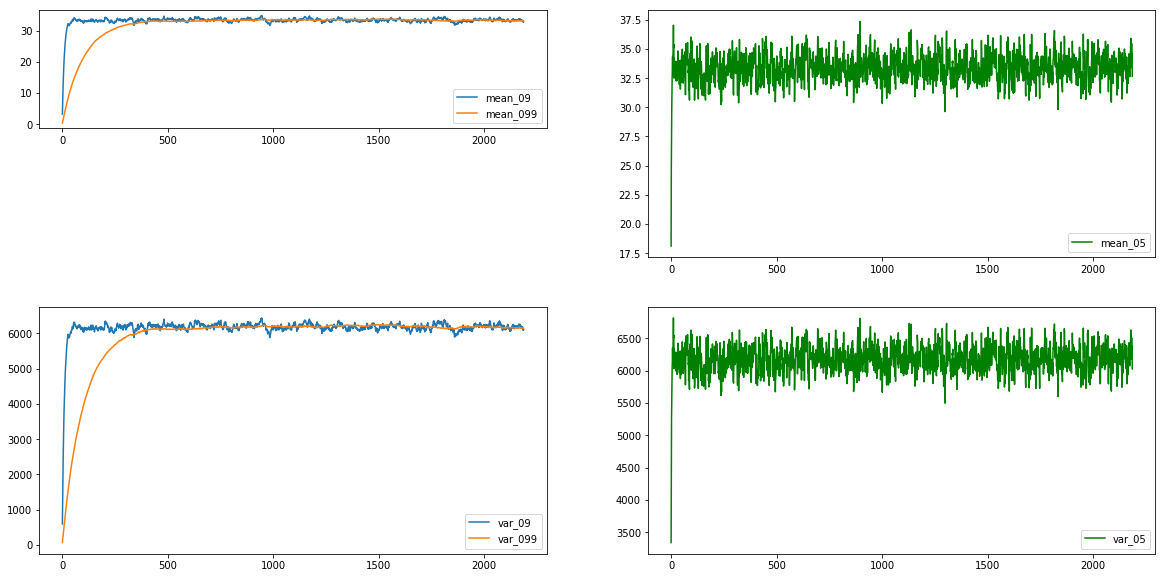

In [21]:
plt.figure(figsize=(20,10))
ax = plt.subplot(4,2,1)
ax.plot(mean_curve_09,label="mean_09")
ax.plot(mean_curve_099,label="mean_099")
ax.legend()
ax = plt.subplot(2,2,2)
ax.plot(mean_curve_05,label="mean_05",  color='g')
ax.legend()
ax = plt.subplot(2,2,3)
ax.plot(var_curve_09,label="var_09",)
ax.plot(var_curve_099,label="var_099",)
ax.legend()
ax = plt.subplot(2,2,4)
ax.plot(var_curve_05,label="var_05",  color='g')
ax.legend()

Посмотрим как повлияла батч нормализация на изображения

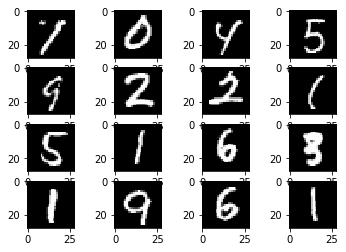

In [22]:
n=4
bn = bn_09
bn.train(False)
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = X[np.random.randint(0, X.shape[0]),0]
    x = torch.Tensor(I)
    I = bn(x.unsqueeze(0)).squeeze(0).squeeze()
    plt.imshow(I, cmap='gray')

# Adam и SGD c моментом

In [23]:
from torch.optim import Optimizer
import math

class Adam(Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        
        defaults = dict(lr=lr, betas=betas, eps=eps)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups
        super(Adam, self).__init__(params, defaults)

    def step(self):
        
        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе
            beta1, beta2 = group['betas'] # betas
            eps = group['eps'] # эпсилон
            lr = group['lr'] # коэффициент обучения
            
            for p in group['params']:
                # итерируемся по всем парамерам в данно группе
                # если нет градиента по параметрам скипаем его
                if p.grad is None:
                    continue
                    
                # забираем тензор градиента    
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]

                # если параметры мы еще не записали инициализируем их значения
                if len(state) == 0:
                    state['step'] = 0
                    # скользящее среднее по градинтам
                    state['avg'] = torch.zeros_like(p.data)
                    # скользящее среднее по квадрату градиентов
                    state['avg_sq'] = torch.zeros_like(p.data)

                # тут можем достать сохраненные состояния
                exp_avg, exp_avg_sq = state['avg'], state['avg_sq']
                        
                # запоминаем шаг 
                state['step'] += 1

                # Считаем параметры. Записывать обратно в state не нужно, ибо мы получаем ссылку
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                step_size = lr * math.sqrt(1 - beta2 ** state['step']) / (1 - beta1 ** state['step']) 
                
                # обновляем веса в p.data, 
                p.data.addcdiv_(-step_size, exp_avg, exp_avg_sq.sqrt() + eps)

        return loss

## SGD + Momentum

In [24]:

class SGD(Optimizer):
    def __init__(self, params, lr, beta=0.9):
        defaults = dict(lr=lr, beta=beta)
        # тут вызываем конструктор базового класса и сохраняем параметры обучения
        # их можно достать через self.param_groups 
        super(SGD, self).__init__(params, defaults)

    def step(self):

        loss = None

        for group in self.param_groups:
            # итерируемся по всем группам параметров нашей сети
            # тут можно вытащить сохраненные параметры в группе            
            beta = group['beta']
            lr = group['lr']
            
            for p in group['params']:
                if p.grad is None:
                    continue
                # gradient                                
                grad = p.grad.data
                
                # тут храняться значения, которые мы расчитываем в процессе 
                # по каждому параметру в группе нужно расчитывать свои значения
                state = self.state[p]
                
                if beta != 0:
                    # тут добавляем момент если он указан
                    if 'momentum' not in state:
                        state['momentum'] = torch.zeros_like(p.data)
                    state['momentum'].mul_(beta).add_((1 - beta), grad)
                    grad = state['momentum']

                # обновляем веса
                p.data.add_(-lr, grad)

        return loss


Тут векторизуем наш выход как OneHotEncoder вектор. Если объект принадлежит классу значение 1 нет 0.

In [25]:
from sklearn.preprocessing import OneHotEncoder

Y = mnist['target'].astype('int')
print('original', Y)


original [0 0 0 ... 9 9 9]


In [26]:
USE_CUDA=False

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    # Слои, в которых нет параметров для обучения можно не создавать, а брать из переменной F
    def __init__(self, dropout=False, batchnorm=False):
        super(Net, self).__init__()
        #
        # спецальный модуль, который позволяет 
        # объединять компоненты
        self.net = nn.Sequential(nn.BatchNorm2d(1))
        
        # вход 28x28, выход 24x24 (28-5)/1 + 1 = 24
        self.net.add_module('conv_1', nn.Conv2d(1, 8, kernel_size=5, stride=1))
        self.net.add_module('relu_1', nn.ReLU())  
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_1', nn.BatchNorm2d(8))
        if dropout: self.net.add_module('do_1', nn.Dropout(0.5))
        
        # конволюция, которая уменьшает размер картинки в два раза 
        # (24-2)/2+1 = 12, либо используем nn.MaxPool2d
        self.net.add_module('pool_1', nn.Conv2d(8, 8, kernel_size=2, stride=2)) 
        
        # далее conv->relu->pool
        self.net.add_module('conv_2', nn.Conv2d(8, 16, 5)) # in 12x12, out 8x8
        self.net.add_module('relu_2', nn.ReLU() ) 
        
        # добавляем дропаут и бн
        if batchnorm: self.net.add_module('bn_2', nn.BatchNorm2d(16))
        if dropout: self.net.add_module('do_2', nn.Dropout(0.5))
            
        self.net.add_module('pool_2', nn.MaxPool2d(kernel_size=2, stride=2))                  
        self.fc1 = nn.Linear(16 * 4 * 4, 10)
        # relu

    def forward(self, x):
        x = self.net(x)
        # Вытягиваем многомерный тензор катринки в одну линию
        x = x.view(-1, 16 * 4 * 4)
        x = self.fc1(x)
        x = F.relu(x)
        return x

## Функция обучения модели

In [28]:
def fit_net(c_epoch, network, optimizer):
    loss_fn = torch.nn.CrossEntropyLoss()
    if USE_CUDA:
        loss_fn = loss_fn.cuda()

    batch_size = 32
    loss_curve = []

    for iter in range(c_epoch):
        Xperm = np.random.permutation(X.shape[0])
        loss_acc = 0
        nbatches = X.shape[0]//batch_size
        for b in range(nbatches):
            optimizer.zero_grad()  
            batch_idxs = Xperm[b*batch_size:(b+1)*batch_size]
            x = torch.Tensor(X[batch_idxs])
            y = torch.from_numpy(Y[batch_idxs]).long()
            if USE_CUDA:
                x = x.cuda()
                y = y.cuda()
            y_pred = network(x)
            loss = loss_fn(y_pred, y)
            loss_acc += float( loss[0] )
            loss.backward() # <-- тут расчитывается градиент
            optimizer.step()  # <-- тут происходит обновление весов
        avg_epoch_loss = loss_acc / (nbatches)
        print('Do epoch %s with loss %s' % (iter, avg_epoch_loss ))
        loss_curve.append(avg_epoch_loss)
    
    return loss_curve

## SGD без момента

In [29]:
learning_rate = 1e-1
net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.0) # создаем оптимизатор с параметрами
loss_curve_sgd = fit_net(20, net, optimizer) # обучаем сеть

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.11122556277399583
Do epoch 1 with loss 0.04508776678292785
Do epoch 2 with loss 0.0358375314508991
Do epoch 3 with loss 0.03051584805726024
Do epoch 4 with loss 0.027354490313428584
Do epoch 5 with loss 0.023591652468262496
Do epoch 6 with loss 0.021350834029801206
Do epoch 7 with loss 0.0192632642704491
Do epoch 8 with loss 0.01798706972536345
Do epoch 9 with loss 0.016361731223363443
Do epoch 10 with loss 0.01597250370495277
Do epoch 11 with loss 0.01360591658049105
Do epoch 12 with loss 0.012273797452804101
Do epoch 13 with loss 0.011861916077861951
Do epoch 14 with loss 0.009442775109531567
Do epoch 15 with loss 0.00883655233720039
Do epoch 16 with loss 0.008807392188769036
Do epoch 17 with loss 0.008223871335516686
Do epoch 18 with loss 0.007727043843727217
Do epoch 19 with loss 0.006982848545596869


# Кривые обучения SGD без момента

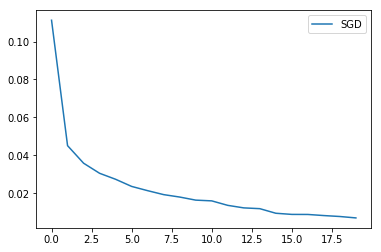

In [30]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd,label="SGD")
ax.legend()

## SGD с моментом

In [31]:
learning_rate = 1e-1

net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.9)
loss_curve_sgd_momentum_1 = fit_net(20, net, optimizer)

learning_rate = 1e-2

net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.99)
loss_curve_sgd_momentum_2 = fit_net(20, net, optimizer)

learning_rate = 1e-3

net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = SGD(net.parameters(), lr=learning_rate, beta=0.5)
loss_curve_sgd_momentum_3 = fit_net(20, net, optimizer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 0.12233411529406762
Do epoch 1 with loss 0.04555804955602292
Do epoch 2 with loss 0.03536104428942584
Do epoch 3 with loss 0.03001694749848288
Do epoch 4 with loss 0.026560102876021976
Do epoch 5 with loss 0.023797611582889698
Do epoch 6 with loss 0.020747087418924035
Do epoch 7 with loss 0.018715734085537387
Do epoch 8 with loss 0.017698751514667672
Do epoch 9 with loss 0.01556875935538915
Do epoch 10 with loss 0.015413698744136119
Do epoch 11 with loss 0.013895442269003222
Do epoch 12 with loss 0.013296340279209597
Do epoch 13 with loss 0.011011184382694848
Do epoch 14 with loss 0.011787135646285453
Do epoch 15 with loss 0.009266462577332303
Do epoch 16 with loss 0.009358033207409121
Do epoch 17 with loss 0.007700974974231083
Do epoch 18 with loss 0.007772639618652512
Do epoch 19 with loss 0.007141549213460226
Do epoch 0 with loss 0.4923560419173125
Do epoch 1 with loss 0.08396926405062455
Do epoch 2 with loss 0.0624393815465125
Do epoch 3 with loss 0.05082392682

# Кривые обучения SGD с моментом

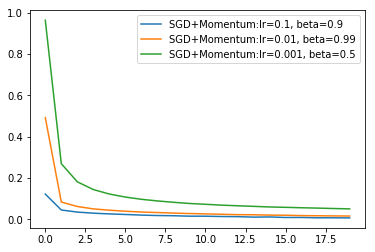

In [32]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_sgd_momentum_1,label="SGD+Momentum:lr=0.1, beta=0.9")
ax.plot(loss_curve_sgd_momentum_2,label="SGD+Momentum:lr=0.01, beta=0.99")
ax.plot(loss_curve_sgd_momentum_3,label="SGD+Momentum:lr=0.001, beta=0.5")
ax.legend()

## Adam

In [33]:
learning_rate = 1e-1

net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_1 = fit_net(20, net, optimizer)

learning_rate = 1e-2

net = Net(batchnorm=True)
net = net.cuda() if USE_CUDA else net
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_2 = fit_net(20, net, optimizer)

learning_rate = 1e-3

net = Net(batchnorm=True) # инициализация сети
net = net.cuda() if USE_CUDA else net # если нужно тащим ее на GPU
optimizer = Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))
loss_curve_adam_3 = fit_net(20, net, optimizer)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Do epoch 0 with loss 2.303230346475609
Do epoch 1 with loss 2.3025848865509033
Do epoch 2 with loss 2.3025848865509033
Do epoch 3 with loss 2.3025848865509033
Do epoch 4 with loss 2.3025848865509033
Do epoch 5 with loss 2.3025848865509033
Do epoch 6 with loss 2.3025848865509033
Do epoch 7 with loss 2.3025848865509033
Do epoch 8 with loss 2.3025848865509033
Do epoch 9 with loss 2.3025848865509033
Do epoch 10 with loss 2.3025848865509033
Do epoch 11 with loss 2.3025848865509033
Do epoch 12 with loss 2.3025848865509033
Do epoch 13 with loss 2.3025848865509033
Do epoch 14 with loss 2.3025848865509033
Do epoch 15 with loss 2.3025848865509033
Do epoch 16 with loss 2.3025848865509033
Do epoch 17 with loss 2.3025848865509033
Do epoch 18 with loss 2.3025848865509033
Do epoch 19 with loss 2.3025848865509033
Do epoch 0 with loss 0.4066857163784544
Do epoch 1 with loss 0.2853016386708823
Do epoch 2 with loss 0.27713305815529704
Do epoch 3 with loss 0.2716040780651117
Do epoch 4 with loss 0.2680615

# Кривые обучения Adam

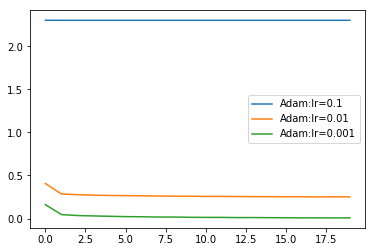

In [34]:
ax = plt.subplot(1,1,1)
ax.plot(loss_curve_adam_1,label="Adam:lr=0.1")
ax.plot(loss_curve_adam_2,label="Adam:lr=0.01")
ax.plot(loss_curve_adam_3,label="Adam:lr=0.001")
ax.legend()

### Выводы

In [ ]:
SGD - эпохи считает медленно, но результат очень хороший даже при lr=0.1, при увеличении lr будет считать дольше
SGD + momentum - эпоху считает быстрее SGD, но сходится к результату SGD дольше, лучше всего работает при больших значениях beta
Adam - эпохи считает быстрее всех и сходится к результату почти так же как и SGD, 
судя по графику будет сходиться быстрее к минимуму при стремлении lr к нулю